In [7]:
#Data processing, clustering, and PCA

import pandas as pd 
import numpy as np 
import plotly.express as px
import plotly.colors as pc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

df = pd.read_csv("FinalElimData.csv") #reads in csv file
my_array = df.values  # converts dataframe to numpy array

#Ordinal normalization
def normalize_array_by_ranking(arr):
    # Get the shape of the array
    rows, cols = arr.shape

    # Initialize a new array to store the normalized values and set it to NaN
    normalized_arr = np.full((rows, cols), np.nan)
    
    # Iterate through each row and replace non-NaN values with their rankings
    for i in range(rows):
        row = arr[i, :]
        non_nan_indices = np.logical_not(np.isnan(row))
        ranking = np.argsort(np.argsort(row[non_nan_indices]))
        normalized_arr[i, non_nan_indices] = ranking
    
    return normalized_arr

#Use for C–H Activation data - make sure this line is commented if not using
#normalized_array = normalize_array_by_ranking(my_array)

#Vector normalization (use for elimination and phenol data - make sure this is commented if not using)
normalized_array = preprocessing.normalize(my_array)

#choose number of clusters
number_of_clusters = 3

#runs k means algorithm on data
KMeans = KMeans(n_clusters=number_of_clusters, random_state=13, n_init=10)
clusters = KMeans.fit_predict(normalized_array)

# Define a list of colors
base_dark_colors = [
    'rgb(178,34,34)',
    'rgb(34,139,34)',
    'rgb(123,104,238)',
    'rgb(138,43,226)',
    'rgb(160,82,45)',
    'rgb(199,21,133)',
    'rgb(105,105,105)'
]

# Repeat and truncate the list to match number of clusters
dark_colors = (base_dark_colors * ((number_of_clusters // len(base_dark_colors)) + 1))[:number_of_clusters]

# Create symbol and color dictionary for clusters
symbols = ['circle', 'square', 'diamond', 'cross', 'x', 'triangle-up', 'triangle-down', 'triangle-left', 'triangle-right', 'hexagram'] * (number_of_clusters // 10 + 1)
symbols = symbols[:number_of_clusters]
cluster_to_color_dictionary = {str(i): dark_colors[i] for i in range(number_of_clusters)}
cluster_to_symbol_dictionary = {i: symbols[i] for i in range(number_of_clusters)}

#prints out clustering results
print("list of clusters by condition:")
print(clusters)

#PCA to visualize data points and clustering
pca = PCA(n_components=3)
embedding = pca.fit_transform(normalized_array)

# Prepare dataframe for Plotly
plot_df = pd.DataFrame({
    'PC1': embedding[:, 0],
    'PC2': embedding[:, 1],
    'PC3': embedding[:, 2],  # Include PC3 here
    'Cluster': clusters.astype(str),
    'Symbol': [cluster_to_symbol_dictionary[label] for label in clusters]
})

# Plot PCA with clustering results
fig3 = px.scatter(
    plot_df,
    x='PC1',
    y='PC2',
    color='Cluster',
    symbol='Symbol',
    color_discrete_map=cluster_to_color_dictionary,
    width=1500,
    height=750
)

# Add annotations
for i, entry_number in enumerate(range(len(normalized_array))):
    fig3.add_annotation(
        x=embedding[i, 0],
        y=embedding[i, 1],
        text=str(entry_number),
        showarrow=False,
        font=dict(color="white", size=30)
    )

fig3.update_traces(marker_size=35)
fig3.show()

# Calculate and print explained variance ratios
explained_variance = pca.explained_variance_ratio_
total_variance = np.sum(explained_variance)

print("Explained variance by principal components:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.2%}")

print(f"Total variance explained by first 3 components: {total_variance:.2%}")

list of clusters by condition:
[0 0 0 2 2 2 1 1 1]


Explained variance by principal components:
PC1: 68.39%
PC2: 16.88%
PC3: 12.82%
Total variance explained by first 3 components: 98.09%


In [8]:
# Test dataset for clustering performance with different random seeds

from collections import Counter
from sklearn.cluster import KMeans
import numpy as np

num_clusters = 3  # Change as needed
num_runs = 1000

# Counter to store the frequency of each unique clustering
clustering_counts = Counter()

for seed in range(num_runs):
    kmeans = KMeans(n_clusters=num_clusters, random_state=seed, n_init=10)
    kmeans.fit(normalized_array)
    
    # Directly store the labels as a tuple
    clustering_counts[tuple(kmeans.labels_)] += 1

# Display the results
print(f"Number of unique cluster groupings over {num_runs} random seeds: {len(clustering_counts)}")
for i, (clustering, count) in enumerate(clustering_counts.items(), 1):
    print(f"Clustering {i}: {clustering} - Occurrences: {count}")


Number of unique cluster groupings over 1000 random seeds: 6
Clustering 1: (1, 1, 1, 2, 2, 2, 0, 0, 0) - Occurrences: 413
Clustering 2: (1, 1, 1, 0, 0, 0, 2, 2, 2) - Occurrences: 330
Clustering 3: (0, 0, 0, 2, 2, 2, 1, 1, 1) - Occurrences: 186
Clustering 4: (0, 0, 0, 1, 1, 1, 2, 2, 2) - Occurrences: 55
Clustering 5: (2, 2, 2, 0, 0, 0, 1, 1, 1) - Occurrences: 11
Clustering 6: (2, 2, 2, 1, 1, 1, 0, 0, 0) - Occurrences: 5


In [9]:
#Test dataset for performance with random noise (general)

from sklearn.cluster import KMeans
from collections import defaultdict

# Function to modify all values per row
def modify_array(arr):
    modified_arr = arr.copy()
    rows, cols = modified_arr.shape
    
    for i in range(rows):
        for j in range(cols):
            if modified_arr[i, j] != -1:
                change = np.random.randint(0, 6)  # Random number between 0 and 5
                # Randomly decide whether to add or subtract the number
                modified_arr[i, j] += np.random.choice([-change, change])
                
                # Ensure values don't exceed 100 or go below 0
                modified_arr[i, j] = max(0, min(modified_arr[i, j], 100))
    
    return modified_arr

# Function to perform actual clustering
def cluster_data(arr):
    """Clusters the data into 3 groups using KMeans"""
    kmeans = KMeans(n_clusters=3, random_state=13, init="k-means++")
    cluster_labels = kmeans.fit_predict(arr)
    return cluster_labels

# Dictionary to track occurrences of unique clusters
cluster_counts = defaultdict(int)

# Run the modification 1000 times
for _ in range(1000):
    modified_data = modify_array(my_array)
    #normalized_data = normalize_array_by_ranking(modified_data)  # C–H Activation normalization
    normalized_data = preprocessing.normalize(modified_data) #Elim/Phenol normalization
    cluster_result = cluster_data(normalized_data)  # Get cluster assignments
    
    cluster_tuple = tuple(cluster_result)  # Convert array to hashable format
    cluster_counts[cluster_tuple] += 1

# Display results
print("Number of times each unique modified dataset clustering appeared:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster} appeared {count} times")

Number of times each unique modified dataset clustering appeared:
Cluster (0, 0, 0, 2, 2, 2, 1, 1, 1) appeared 656 times
Cluster (0, 0, 0, 1, 1, 1, 2, 2, 2) appeared 13 times
Cluster (0, 2, 0, 1, 1, 1, 1, 1, 1) appeared 179 times
Cluster (0, 0, 0, 2, 2, 1, 1, 1, 1) appeared 1 times
Cluster (2, 0, 2, 1, 1, 1, 1, 1, 1) appeared 63 times
Cluster (1, 2, 1, 0, 0, 0, 0, 0, 0) appeared 66 times
Cluster (2, 1, 2, 0, 0, 0, 0, 0, 0) appeared 22 times


In [10]:
#ARI scores for Elimination clustering

import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn import preprocessing

def modify_array(arr):
    modified_arr = arr.copy()
    rows, cols = modified_arr.shape
    
    for i in range(rows):
        for j in range(cols):
            if modified_arr[i, j] != -1:
                change = np.random.randint(0, 6)  # Random number between 0 and 5
                modified_arr[i, j] += np.random.choice([-change, change])  # Add or subtract change
                modified_arr[i, j] = max(0, min(modified_arr[i, j], 100))  # Ensure values don't exceed 100
    
    return modified_arr

# Load dataset
df = pd.read_csv("FinalElimData.csv")
my_array = df.values

# Ground truth labels for 9 points
true_labels = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])

if len(my_array) != len(true_labels):
    raise ValueError(f"Mismatch: dataset has {len(my_array)} rows, but expected {len(true_labels)} labels.")

num_clusters = len(set(true_labels))
ari_scores = []
unique_clusterings = {}

for trial in range(1, 101):
    modified_array = modify_array(my_array)
    normalized_array = preprocessing.normalize(modified_array)
    
    kmeans = KMeans(n_clusters=num_clusters, init="k-means++", random_state=13, n_init=10)
    pred_labels = kmeans.fit_predict(normalized_array)
    ari = adjusted_rand_score(true_labels, pred_labels)
    ari_scores.append(ari)
    
    cluster_tuple = tuple(pred_labels)
    unique_clusterings[cluster_tuple] = unique_clusterings.get(cluster_tuple, 0) + 1
    
    print(f"Trial {trial}: ARI Score = {ari:.4f}")

avg_ari = np.mean(ari_scores)
num_unique_clusterings = len(unique_clusterings)
most_common_clustering = max(unique_clusterings.values())

print("\nFinal Results:")
print(f"Average ARI over 100 trials: {avg_ari:.4f}")
print(f"Number of unique clustering results: {num_unique_clusterings}")
print(f"Most common clustering appeared {most_common_clustering} times.")


Trial 1: ARI Score = 0.3529
Trial 2: ARI Score = 0.3529
Trial 3: ARI Score = 1.0000
Trial 4: ARI Score = 1.0000
Trial 5: ARI Score = 1.0000
Trial 6: ARI Score = 0.3529
Trial 7: ARI Score = 1.0000
Trial 8: ARI Score = 0.3529
Trial 9: ARI Score = 0.3529
Trial 10: ARI Score = 0.3529
Trial 11: ARI Score = 0.3529
Trial 12: ARI Score = 1.0000
Trial 13: ARI Score = 1.0000
Trial 14: ARI Score = 1.0000
Trial 15: ARI Score = 1.0000
Trial 16: ARI Score = 1.0000
Trial 17: ARI Score = 0.3529
Trial 18: ARI Score = 1.0000
Trial 19: ARI Score = 1.0000
Trial 20: ARI Score = 1.0000
Trial 21: ARI Score = 0.3529
Trial 22: ARI Score = 1.0000
Trial 23: ARI Score = 1.0000
Trial 24: ARI Score = 1.0000
Trial 25: ARI Score = 1.0000
Trial 26: ARI Score = 0.3529
Trial 27: ARI Score = 0.3529
Trial 28: ARI Score = 1.0000
Trial 29: ARI Score = 1.0000
Trial 30: ARI Score = 0.3529
Trial 31: ARI Score = 1.0000
Trial 32: ARI Score = 1.0000
Trial 33: ARI Score = 0.3529
Trial 34: ARI Score = 0.3529
Trial 35: ARI Score = 0

In [6]:
#ARI scores for C–H Activation clustering

import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

df = pd.read_csv("CHActivationFinal.csv") #reads in csv file
my_array = df.values  # converts dataframe to numpy array

# Function to modify all values per row
def modify_array(arr):
    modified_arr = arr.copy()
    rows, cols = modified_arr.shape
    
    for i in range(rows):
        for j in range(cols):
            if modified_arr[i, j] != -1:
                change = np.random.randint(0,6)  # Random number between 0 and 5
                modified_arr[i, j] += np.random.choice([-change, change])  # Add or subtract change
                # Ensure values don't exceed 100
                modified_arr[i, j] = max(0, min(modified_arr[i, j], 100))
    
    return modified_arr

# Ordinal normalization function
def normalize_array_by_ranking(arr):
    # Get the shape of the array
    rows, cols = arr.shape

    # Initialize a new array to store the normalized values and set it to NaN
    normalized_arr = np.full((rows, cols), np.nan)
    
    # Iterate through each row and replace non-NaN values with their rankings
    for i in range(rows):
        row = arr[i, :]
        non_nan_indices = np.logical_not(np.isnan(row))
        ranking = np.argsort(np.argsort(row[non_nan_indices]))
        normalized_arr[i, non_nan_indices] = ranking
    
    return normalized_arr

# Ground truth labels (corresponding to the 21 C–H activation data points)
true_labels = np.array([2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 
                        1, 1, 1, 1, 1, 1, 1, 1, 1])  # 21 elements

# Ensure the number of labels matches the number of data points
if len(my_array) != len(true_labels):
    raise ValueError(f"Mismatch: normalized_array has {len(my_array)} rows, but true_labels has {len(true_labels)} labels.")

# Number of unique clusters in ground truth
num_clusters = len(set(true_labels))

# Run 100 modifications and compute ARI scores
ari_scores = []
clustering_results = []  # Store all clusterings
unique_clusterings = {}  # Dictionary to track occurrences

for trial in range(1, 101):
    # Step 1: Modify the original data (before normalization)
    modified_array = modify_array(my_array)  # Apply modification
    
    # Step 2: Normalize the modified data
    normalized_array = normalize_array_by_ranking(modified_array)  # Normalize after modification
    
    # Step 3: Run KMeans on the normalized data
    kmeans = KMeans(n_clusters=num_clusters, init="k-means++", random_state=13, n_init=10)  # KMeans initialization
    pred_labels = kmeans.fit_predict(normalized_array)  # Cluster modified data
    ari = adjusted_rand_score(true_labels, pred_labels)  # Compute ARI
    ari_scores.append(ari)
    
    # Convert cluster labels to a tuple (hashable for dictionary comparison)
    cluster_tuple = tuple(pred_labels)
    
    # Track the number of times each unique clustering appears
    if cluster_tuple in unique_clusterings:
        unique_clusterings[cluster_tuple] += 1
    else:
        unique_clusterings[cluster_tuple] = 1
    
    # Print results for each trial
    print(f"\nTrial {trial}:")
    print(f"Clusters: {pred_labels}")
    print(f"ARI Score: {ari:.4f}")

# Compute and print summary statistics
avg_ari = np.mean(ari_scores)
num_unique_clusterings = len(unique_clusterings)

print("\nFinal Results:")
print(f"Average ARI over 100 trials: {avg_ari:.4f}")
print(f"Number of unique clustering results: {num_unique_clusterings}")


Trial 1:
Clusters: [0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 2 1 1 1 1]
ARI Score: 0.8286

Trial 2:
Clusters: [1 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 2 0 0 0 0]
ARI Score: 0.7643

Trial 3:
Clusters: [2 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
ARI Score: 1.0000

Trial 4:
Clusters: [1 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 2 0 0 0 0]
ARI Score: 0.7643

Trial 5:
Clusters: [0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1]
ARI Score: 1.0000

Trial 6:
Clusters: [1 1 1 1 2 2 2 2 2 2 2 2 0 0 0 0 1 0 0 0 0]
ARI Score: 0.8696

Trial 7:
Clusters: [0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 2 1 1 1 1]
ARI Score: 0.8286

Trial 8:
Clusters: [1 2 1 2 1 1 1 1 1 1 1 1 0 2 0 0 2 0 0 0 2]
ARI Score: 0.5286

Trial 9:
Clusters: [1 2 1 2 1 1 1 1 1 1 1 1 0 2 0 1 2 0 0 0 2]
ARI Score: 0.3789

Trial 10:
Clusters: [1 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 2 0 0 0 0]
ARI Score: 0.7643

Trial 11:
Clusters: [2 0 2 2 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0]
ARI Score: 0.7158

Trial 12:
Clusters: [0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1]
ARI Score: 1.0000

Trial 13:
Cl

In [20]:
#S Scores for Phenol Data

import pandas as pd 
import numpy as np 
import plotly.express as px
import plotly.colors as pc
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from collections import defaultdict

# Load data
df = pd.read_csv("PhenolDataFinal.csv")
my_array = df.values 

# #Vector normalization (use for elimination data - make sure this is commented if not using)
normalized_array = preprocessing.normalize(my_array)

# Clustering parameters
number_of_clusters = 5
num_trials = 1000
target_index = 2
co_occurrence_counts = np.zeros(len(normalized_array))

# Run clustering multiple times
for seed in range(num_trials):
    kmeans = KMeans(n_clusters=number_of_clusters, init="k-means++", random_state=seed)
    clusters = kmeans.fit_predict(normalized_array)
    target_cluster = clusters[target_index]
    co_occurrence_counts += (clusters == target_cluster)

# Compute S scores
S_scores = co_occurrence_counts / num_trials

# Print S scores
for idx, score in enumerate(S_scores):
    if idx != target_index:
        print(f"Data point {idx}: S = {score:.2f}")


Data point 0: S = 0.00
Data point 1: S = 0.98
Data point 3: S = 0.09
Data point 4: S = 0.38
Data point 5: S = 0.09
Data point 6: S = 0.04
Data point 7: S = 0.04
Data point 8: S = 0.00
Data point 9: S = 0.00
Data point 10: S = 0.03
Data point 11: S = 0.00
Data point 12: S = 0.02
Data point 13: S = 0.82
Data point 14: S = 0.00
Data point 15: S = 0.18
Data point 16: S = 0.01
Data point 17: S = 0.00
Data point 18: S = 0.00
Data point 19: S = 0.02
Data point 20: S = 0.01
Data point 21: S = 0.00
Data point 22: S = 0.01
Data point 23: S = 0.00


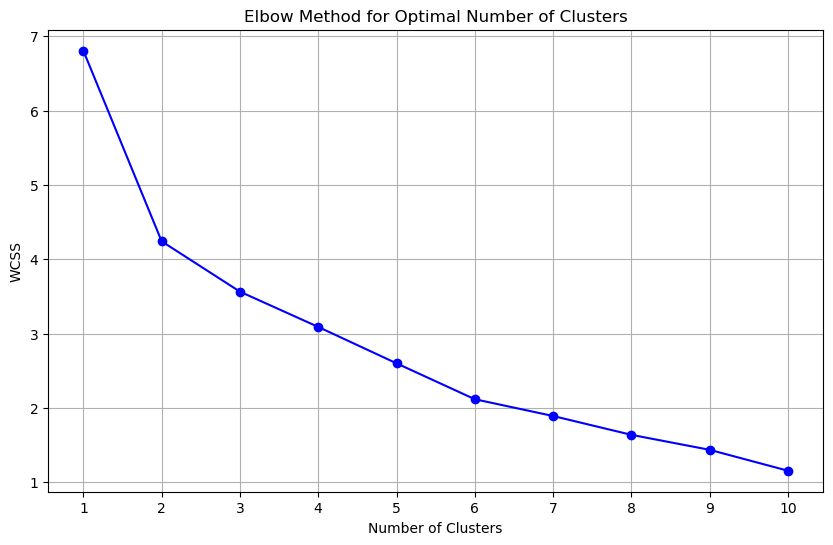

In [21]:
# Determine optimal number of clusters using the elbow method - use only if unsure of # clusters needed
wcss = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=13)
    kmeans.fit(normalized_array)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

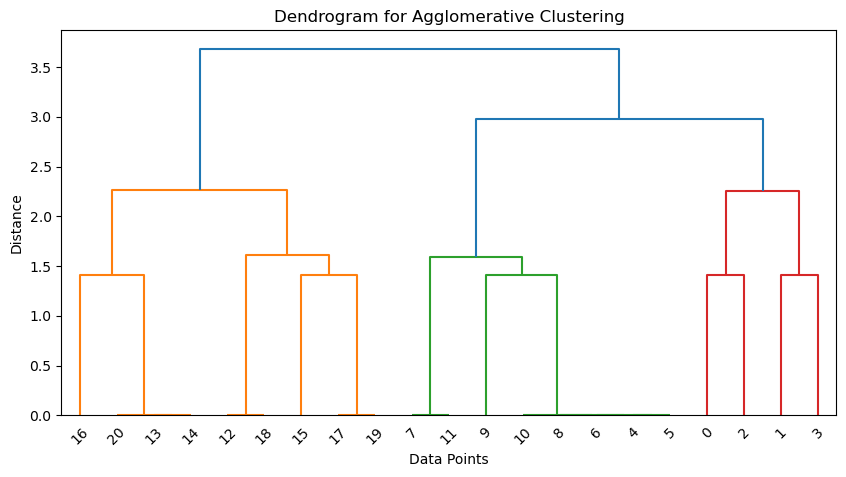

list of clusters by condition:
[1 1 1 1 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]


In [21]:
#Agglomerative Clustering - need to run directly after running first block

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Plot the dendrogram
plt.figure(figsize=(10, 5))
linkage_matrix = sch.linkage(normalized_array, method="average")
sch.dendrogram(linkage_matrix)
plt.title("Dendrogram for Agglomerative Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

Agglomerative = AgglomerativeClustering(n_clusters=number_of_clusters)
clusters = Agglomerative.fit_predict(normalized_array)

#prints out results
print("list of clusters by condition:")
print(clusters)

In [22]:
# Python version: 3.7.15 (default, Nov 24 2022, 12:02:37) 
# [Clang 14.0.6 ]
# numpy version: 1.21.5
# pandas version: 1.3.5
# scikit-learn version: 1.0.2